# [Module 1.1] Personalize Data File 준비

MovieLens 데이터 세트에서 수집된 데이터를 기반으로, 영화에 대한 추천 모델을 작성하는 법을 안내합니다. 목표는 특정 사용자를 기반으로 하는 영화를 추천하는 것입니다.<br>
이 노트북에서는 전체적으로 데이타를 준비하는 단계입니다. 그러기 위해서 아래와 같은 작업을 수행 합니다. <br>

* S3 버킷 설정, 데이타 다운로드 및 S3에 데이타 업로드
* 데이타 스키마 생성
* 데이타 세트 그룹 생성 (DatasetGroup)
* 데이타 세트 생성 (Dataset)
* 환경 설정 (S3 버킷에 정책(Policy) 부여, Personalize 역할(Role) 생성)
* 데이타 Import (S3 --> Personalize 서비스로 이동)

이 노트북을 모두 실행하는데 걸리는 시간은 약 20 ~ 30 분 소요 됩니다.

#### Notebook 사용법

코드는 여러 코드 셀들로 구성됩니다. 이 페이지의 상단에 삼각형으로 된 실행 단추를 마우스로 클릭하여 각 셀을 실행하고 다음 셀로 이동할 수 있습니다. 또는 셀에서 키보드 단축키 `Shift + Enter`를 눌러 셀을 실행하고 다음 셀로 이동할 수도 있습니다.

셀이 실행되면 셀이 실행되는 동안 측면에 줄이 * 표시되어 있거나 셀 내의 모든 코드를 예측한 후 실행이 완료된 마지막 셀을 나타내기 위해 숫자로 업데이트됩니다.

아래 지침을 따르고 셀을 실행하여 Amazon Personalize를 시작하세요.

#### Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
# Imports
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

## MovieLens 데이터를 다운로드 받습니다. 

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록



### 데이터 세트 다운로드 및 탐색

In [2]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip
df_all = pd.read_csv('./ml-1m/ratings.dat',sep='::',names=['USER_ID','ITEM_ID','EVENT_VALUE', 'TIMESTAMP'])
df_all['EVENT_TYPE']='RATING'
items_all = pd.read_csv('./ml-1m/movies.dat',sep='::', encoding='latin1',names=['ITEM_ID', '_TITLE', 'GENRE'],)
del items_all['_TITLE']
pd.set_option('display.max_rows', 5)

--2020-08-30 06:46:03--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ml-1m.zip’ not modified on server. Omitting download.

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


## 데이타 형태 확인하기

데이터를 한번 확인해 봅니다.

In [3]:
items = items_all.copy()
items

,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


In [4]:
df = df_all.copy()
df

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,1193,5,978300760,RATING
1,1,661,3,978302109,RATING
...,...,...,...,...,...
1000207,6040,1096,4,956715648,RATING
1000208,6040,1097,4,956715569,RATING


In [5]:
from utils import get_readable_date
    
print("978300760: ", get_readable_date(int(978300760)))
print("978302109: ", get_readable_date(int(978302109)))


978300760:  2000-12-31 22:12:40
978302109:  2000-12-31 22:35:09


In [6]:
# 컬럼별 유니크 갯수
df.nunique()

USER_ID          6040
ITEM_ID          3706
EVENT_VALUE         5
TIMESTAMP      458455
EVENT_TYPE          1
dtype: int64

In [7]:
# 유저별로 몇 개의 인터랙션이 있는지 하위, 상위 5개씩 보기
print(df.groupby('USER_ID').ITEM_ID.count().nsmallest(5))
print(df.groupby('USER_ID').ITEM_ID.count().nlargest(5))

USER_ID
98     20
160    20
217    20
250    20
311    20
Name: ITEM_ID, dtype: int64
USER_ID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: ITEM_ID, dtype: int64


##  데이터 준비 

이 데이터에는 UserID, ItemID, Rating 및 Timestamp 컬럼이 포함되어 있습니다.<br>

    1) Cold Start item 테스트를 위해 고유한 아이템 50% 에대한 interaction 데이터를 분리합니다. 
       * Coldstart 테스트 용으로는 더 적은 데이터만 남기셔도 됩니다. 
         이번 Lab에서는 Training 시간 단축을 위해 50%정도 데이터만 학습에 사용합니다. 
    2) 모델 완성 후 성능 검증하기 위해 남은 데이터에서 추가로 모든 사용자의 마지막 10% 데이터를 분리합니다.
![image.png](static/imgs/img_datasplit50_v1.JPG)


#### 1) Cold Start item에 따라 Interaction 분리하기 

unique items을 구하고 warm_items, cold_items를 50%, 50% 씩 나눕니다.

In [8]:
# Create list of unique items
unique_items = df['ITEM_ID'].unique()
unique_items = np.random.RandomState(seed=42).permutation(unique_items)
print("# of Unique Items: ", len(unique_items))


# of Unique Items:  3706


In [9]:
warm_items = unique_items[len(unique_items)//2:]
cold_items = unique_items[:len(unique_items)//2]
print("The number of Warm_items: {}".format(len(warm_items)))
print("The number of Cold_items: {}".format(len(cold_items)))

The number of Warm_items: 1853
The number of Cold_items: 1853


In [10]:
print(np.sort(warm_items))
print(np.sort(cold_items))

[   1    3    6 ... 3948 3949 3951]
[   2    4    5 ... 3945 3950 3952]


In [11]:
def split_dataset(df, distinct_items):
    split_df = df.copy()
    #Create Training data with only Warm-item
    split_df['to_keep'] = split_df['ITEM_ID'].apply(lambda x:x in distinct_items)
    split_df =split_df [split_df['to_keep']]
    del split_df['to_keep']
    return split_df

#### Warm Data Set 정보
전체 데이터의 50% 인 warm_items로 구성된 Train 데이터 입니다.

In [12]:
#Create Training data with only Warm-item
df_warm = split_dataset(df, warm_items)
print(df_warm.nunique())

USER_ID          6040
ITEM_ID          1853
EVENT_VALUE         5
TIMESTAMP      307535
EVENT_TYPE          1
dtype: int64


#### ColdStart Data Set 정보
전체 데이터의 50%인 cold_items로 구성된 ColdStart 데이터 셋 입니다.

In [13]:
#Creat Cold Start interaction data with Cold-item
df_coldstart = split_dataset(df, cold_items)
print(df_coldstart.nunique())

USER_ID          6040
ITEM_ID          1853
EVENT_VALUE         5
TIMESTAMP      317676
EVENT_TYPE          1
dtype: int64


## items 데이타 정리

items 데이타를 전체의 unique_items에 있는 것 만으로 구성 합니다.

In [14]:
#Create metadata with only items in the interaction
df_items = split_dataset(items, unique_items)
df_items

,ITEM_ID,GENRE
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
...,...,...
3881,3951,Drama
3882,3952,Drama|Thriller


#### 2) Warm Data Set을 Train, Validation(holdout) 데이터 분리하기 

모든 사용자의 마지막(Timestamp기준으로) 10%의 데이터를 Validation(Holdout) 데이터로 분리합니다.

In [15]:
pd.options.display.max_rows = 5
def split_holdout(data, pct):
    df = data.copy()
    # Rank per each subgroup, 'USER_ID'
    ranks = df.groupby('USER_ID').TIMESTAMP.rank(pct=True, method='first')
    df = df.join((ranks> pct).to_frame('holdout'))
    
    holdout = df[df['holdout']].drop('holdout', axis=1)
    train = df[~df['holdout']].drop('holdout', axis=1)    
    
    return train, holdout

df_warm_train, df_warm_holdout = split_holdout(df_warm, pct=0.9)

train 과 holdout의 분리된 데이타의 정보입니다. holdout은 대략 전체 대비 10%의 Row의 갯수 입니다. holdout의 timestamp는 train보다 미래의 숫자인 것을 인지할 수 있습니다. (숫자가 많은 것이 더 미래의 날짜를 의미함)

In [16]:
df_warm_train.info()
df_warm_train.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433180 entries, 1 to 1000203
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   USER_ID      433180 non-null  int64 
 1   ITEM_ID      433180 non-null  int64 
 2   EVENT_VALUE  433180 non-null  int64 
 3   TIMESTAMP    433180 non-null  int64 
 4   EVENT_TYPE   433180 non-null  object
dtypes: int64(4), object(1)
memory usage: 19.8+ MB


USER_ID          6040
ITEM_ID          1845
EVENT_VALUE         5
TIMESTAMP      271344
EVENT_TYPE          1
dtype: int64

In [17]:
df_warm_holdout.info()
df_warm_holdout.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51166 entries, 4 to 1000191
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   USER_ID      51166 non-null  int64 
 1   ITEM_ID      51166 non-null  int64 
 2   EVENT_VALUE  51166 non-null  int64 
 3   TIMESTAMP    51166 non-null  int64 
 4   EVENT_TYPE   51166 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.3+ MB


USER_ID         6040
ITEM_ID         1713
EVENT_VALUE        5
TIMESTAMP      38912
EVENT_TYPE         1
dtype: int64

In [18]:
df_warm_train.sort_values(['USER_ID','TIMESTAMP'])

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
27,1,1721,4,978300055,RATING
37,1,1022,5,978300055,RATING
...,...,...,...,...,...
1000005,6040,29,4,960972720,RATING
999995,6040,3547,4,960972741,RATING


In [19]:
df_warm_holdout.sort_values(['USER_ID','TIMESTAMP'])

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
4,1,2355,5,978824291,RATING
35,1,783,4,978824291,RATING
...,...,...,...,...,...
1000172,6040,1784,3,997454464,RATING
1000042,6040,1221,4,998315055,RATING


### Train 데이터의 유저 액티비티 통계

In [20]:
pd.options.display.max_rows = 10
user_activity_counts = df_warm_train.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
user_activity_counts.describe()

,INTERACTION_COUNTS
count,6040.000000
mean,71.718543
std,85.889218
min,2.000000
25%,18.000000
50%,40.000000
75%,90.000000
max,1029.000000


In [21]:
user_interaction_counts=user_activity_counts.reset_index()
activities = user_interaction_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities

,NUM_USERS
INTERACTION_COUNTS,
2,1
3,2
4,6
5,21
6,38
...,...
670,1
717,1
766,1


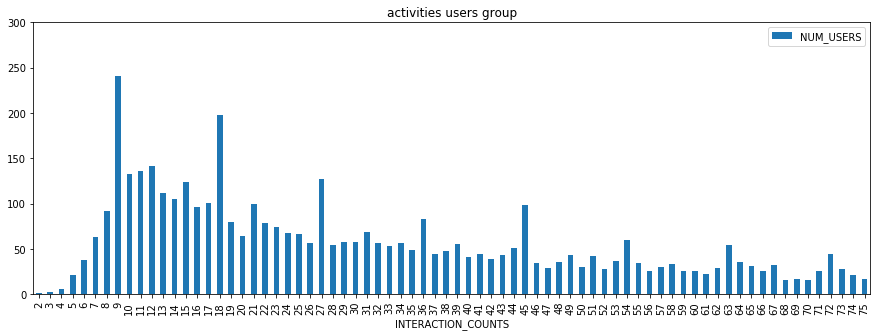

In [22]:
activities.loc[:75,:].plot(kind='bar', figsize=(15,5), ylim=(0,300))
plt.title("activities users group")

plt.show()

## 로컬에 train, item, validation(holdout) 및 coldstart 를 CSV 저장

완료되면 파일을 새 CSV로 저장한 다음, S3에 업로드합니다.<br>

In [23]:
import os
os.makedirs('dataset', exist_ok=True)

train, item, validation(holdout) 데이터를 로컬에 csv 파일로 저장 합니다.

In [24]:
# train, item, validation 로컬 저장
interaction_filename="dataset/training_interaction.csv"
items_filename="dataset/training_item.csv"
validation_interaction_filename="dataset/validation_interaction.csv"

df_warm_train.to_csv(interaction_filename,index=False)
df_items.to_csv(items_filename,index=False)
df_warm_holdout.to_csv(validation_interaction_filename,index=False)      



In [25]:
# coldstart 로컬 저장
coldstart_interation_filename="dataset/coldstart_interaction.csv"
df_coldstart.to_csv(coldstart_interation_filename,index=False)


## S3에 로컬 CSV 업로드

In [26]:
import sagemaker
#bucket='<YOUR BUCKET NAME>' # replace with the name of your S3 bucket
bucket = sagemaker.Session().default_bucket()  

In [27]:
#upload file for training
response_upload = boto3.Session().resource('s3').Bucket(bucket).Object(interaction_filename).upload_file(interaction_filename)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

s3_interaction_filename = "s3://{}/{}".format(bucket, interaction_filename)
s3_items_filename = "s3://{}/{}".format(bucket, items_filename)
print("s3_interaction_filename: \n", s3_interaction_filename)
print("s3_items_filename: \n", s3_items_filename)

#boto3.Session().resource('s3').Bucket(bucket).Object(coldstart_interation_filename).upload_file(coldstart_interation_filename)
#boto3.Session().resource('s3').Bucket(bucket).Object(validation_interaction_filename).upload_file(validation_interaction_filename)


s3_interaction_filename: 
 s3://sagemaker-ap-northeast-2-057716757052/dataset/training_interaction.csv
s3_items_filename: 
 s3://sagemaker-ap-northeast-2-057716757052/dataset/training_item.csv


In [28]:
! aws s3 ls {s3_interaction_filename} --recursive
! aws s3 ls {s3_items_filename} --recursive

2020-08-30 06:46:21   12374389 dataset/training_interaction.csv
2020-08-30 06:46:23      63350 dataset/training_item.csv


In [29]:
response_upload

In [30]:
%store bucket
%store s3_interaction_filename
%store s3_items_filename
%store interaction_filename
%store items_filename
%store validation_interaction_filename
%store coldstart_interation_filename
%store cold_items
%store warm_items
%store unique_items

Stored 'bucket' (str)
Stored 's3_interaction_filename' (str)
Stored 's3_items_filename' (str)
Stored 'interaction_filename' (str)
Stored 'items_filename' (str)
Stored 'validation_interaction_filename' (str)
Stored 'coldstart_interation_filename' (str)
Stored 'cold_items' (ndarray)
Stored 'warm_items' (ndarray)
Stored 'unique_items' (ndarray)
